In [1]:
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt

## Fonction pour lire et nettoyer les données :

In [2]:
def GetData(location,Testset_rate=0.2,sourceLatitude=48.862472,sourceLongitude=2.20116):
    '''
    Cette fonction importe les données et extrait plusieurs tableau utile à la visualisation et l'apprentissage
    
    Input:
        location(Adresse 'C://..'): chemin vers les donnée
        Testset(float)            : Compris entre 0 et 1, donne le pourcentage du test set (par defaut 20%)
        sourceLatitude (float)    : Coordonnée GPS du professionnel, latitude en degrés (par défaut celle donnée)
        sourceLongitude (float)    : Coordonnée GPS du professionnel, longitude en degrés (par défaut celle donnée)
            
    Output: 
        X_train,y_train, X_test,y_test (numpy.array): Quatre tableaux de valeurs pour le machine learning 
        df (dataframe) : Un tableau récapitulant les données
    '''
    
    def Distance(latitude,longitude,sourceLatitude,sourceLongitude):
        '''
    This function return the distance between GPS points
    
    Input:  latitudes and longitudes in degres
            
    Output: distance in km 
        '''
        destLat=latitude*2*pi/360
        sourceLat=sourceLatitude*2*pi/360
        destLong=longitude*2*pi/360
        sourceLong=sourceLongitude*2*pi/360
        R=6378
        d = R * (pi/2 - asin( sin(destLat) * sin(sourceLat) + cos(destLong - sourceLong) * cos(destLat) * cos(sourceLat)))
        d=round(d,2)
        return d
#Import the whole data set
    df = pd.read_csv(location) 

#Only keep interesting data, i.e when it was accepted or refused for distance reason
    df1=df.loc[df['status']=='Accepted']
    df2=df.loc[df['refusal motivation']=='Too far']
    df = pd.concat([df1,df2])
    df['price']=df['price']/100
#Use the function Distance to create a new column containing the distance between user and costumers
    for x in range(len(df.latitude)):
        df.iloc[x,4]=Distance(df.iloc[x,0],df.iloc[x,1],sourceLatitude,sourceLongitude)
    df.rename(columns={'refusal motivation':'distance'},inplace=True)
    from sklearn.preprocessing import LabelEncoder
    labelencoder_df=LabelEncoder()
    df.iloc[:,3]=labelencoder_df.fit_transform(df.iloc[:,3])
    y=df.iloc[:,3].values
    X=df.iloc[:,[2,4]].values
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=Testset_rate,random_state=2)
    return X_train,X_test, y_train,  y_test,df

In [3]:
#mylocation=r'C://Users//Alexandre//Documents//Test Wecasa//propositions.txt'
X_train, X_test, y_train, y_test,df=GetData(r'C://Users//Alexandre//Documents//Test Wecasa//propositions.txt')

## Visualisation des données :

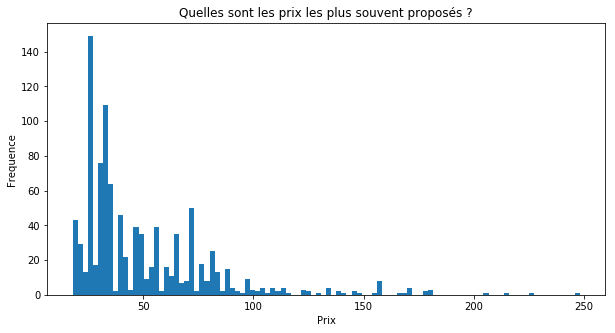

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
_=plt.hist(df['price'],bins=100)
_=plt.title('Quelles sont les prix les plus souvent proposés ?')
_=plt.xlabel('Prix')
_=plt.ylabel('Frequence')
plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.show()

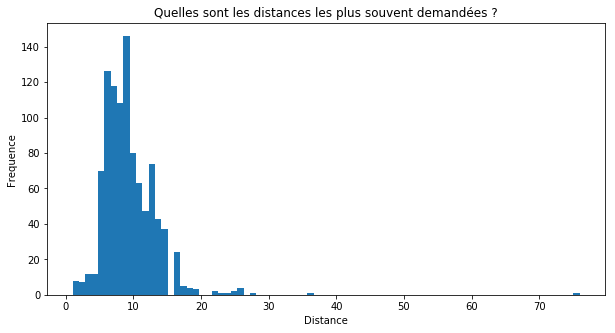

In [5]:
df['newdistance']=''
for x in range(1000):
    df.iloc[x,5]=round(df.iloc[x,4],0)
_=plt.hist(df['newdistance'],bins=80)
_=plt.title('Quelles sont les distances les plus souvent demandées ?')
_=plt.xlabel('Distance')
_=plt.ylabel('Frequence')
plt.show()
del df['newdistance']

In [6]:
def PlotData(X,y):
    '''
    Cette fonction plot l'historique des transactions du professionnel en fonction du prix et de la distance.
    
    Input :
        X (numpy.array) : Un tableau contenant les distances et les prix de chaque historiques
        y (numpy.array) : Un tableau binaires liés à X_train, 0 correspond à une préstation acceptée
    
    Output : Une figure
    '''
    for x in range(len(X)):
        if y[x]==1:
            _=plt.plot(X[x,0], X[x,1], 'ro')
        elif y[x]==0:
            _=plt.plot(X[x,0], X[x,1], 'g*')
    _=plt.title('Répartition des données : en rouge refusées et en verte acceptées')
    _=plt.xlabel('Prix en euros')
    _=plt.ylabel('Distance en kilomètres')
    plt.show()
return ;


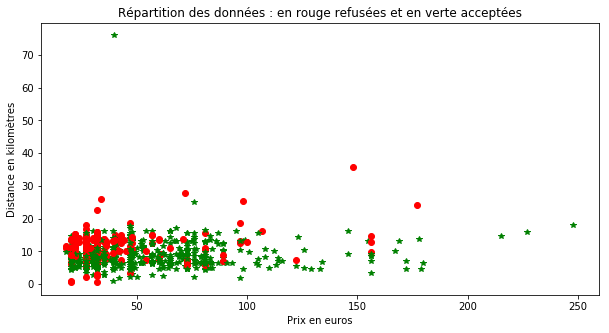

In [7]:
PlotData(X_train,y_train)

## Prédire les futures données :

In [8]:
def PolynomialRegression(X_train,y_train,X_test,y_test):
    '''
    Fonction qui prédit les valeurs de y_test en ajoutant des données polynomales (distance^2,distance^3,distance*prix,prix^2,prix^3)
    puis en utilisant l'algorithme de regression linéaire
    
    Input :
        X_train (numpy.array) : Un tableau contenant les distances et les prix de chaque historiques
        y_train (numpy.array) : Un tableau binaires liés à X_train, 0 correspond à une préstation accepté
        X_test (numpy.array)  : Un tableau contenant les distances et les prix de chaque historiques
        y_test (numpy.array)  : Un tableau binaires liés à X_test 0 correspond à une préstation accepté
        
    Output :
        La "confusion matrix" : Matrice 2x2 contenant les prestations acceptées bien prédites (TP),
        les acceptées mal prédites (FP), les refusées mal prédites (FF) et les refusées bien prédites (TN)
    '''
#Standardisation des données"
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

#Ajout de variables polynomiales
    X_train1=np.c_[X_train,X_train**2,X_train**3,X_train[:,0]*X_train[:,1]]
    X_test1=np.c_[X_test,X_test**2,X_test**3,X_test[:,0]*X_test[:,1]]
# Fitting classifier to the Training set
    from sklearn.linear_model import LogisticRegression
    classifier1 = LogisticRegression(solver='lbfgs')
    classifier1.fit(X_train1,y_train)

# Predicting the Test set results
    y_pred = classifier1.predict(X_test1)

# Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    Recall=cm[0,0]/(cm[0,1]+cm[0,0])
    Precision=cm[0,0]/(cm[1,0]+cm[0,0])
    F_score=2*Precision*Recall/(Precision+Recall)
    print("Le recall de l'algorithme de regression polynomiales est de {:.2f}%, sa précision et de {:.2f}%, et son Fscore de {:.2f}%".format(Recall,Precision,F_score))
    return cm

In [9]:
def NaiveBayes(X_train,y_train,X_test,y_test):
    '''
    Fonction qui prédit les valeurs de y_test en utilisant l'algorithme "NaiveBayes"
    
    Input :
        X_train (numpy.array) : Un tableau contenant les distances et les prix de chaque historiques
        y_train (numpy.array) : Un tableau binaires liés à X_train, 0 correspond à une préstation accepté
        X_test (numpy.array)  : Un tableau contenant les distances et les prix de chaque historiques
        y_test (numpy.array)  : Un tableau binaires liés à X_test 0 correspond à une préstation accepté
        
    Output :
        La "confusion matrix" : Matrice 2x2 contenant les prestations acceptées bien prédites (TP),
        les acceptées mal prédites (FP), les refusées mal prédites (FF) et les refusées bien prédites (TN)
    '''
    from sklearn.naive_bayes import GaussianNB
    classifier2 = GaussianNB()
    classifier2.fit(X_train,y_train)

# Predicting the Test set results
    y_pred = classifier2.predict(X_test)

# Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    Recall=cm[0,0]/(cm[0,1]+cm[0,0])
    Precision=cm[0,0]/(cm[1,0]+cm[0,0])
    F_score=2*Precision*Recall/(Precision+Recall)
    print("Le recall de l'algorithme de NaiveBayes est de {:.2f}%, sa précision et de {:.2f}%, et son Fscore de {:.2f}%".format(Recall,Precision,F_score))
    return cm

In [10]:
cm1=PolynomialRegression(X_train,y_train,X_test,y_test)
cm2=NaiveBayes(X_train,y_train,X_test,y_test)
cm1,cm2

Le recall de l'algorithme de regression polynomiales est de 0.99%, sa précision et de 0.83%, et son Fscore de 0.90%
Le recall de l'algorithme de NaiveBayes est de 0.99%, sa précision et de 0.77%, et son Fscore de 0.87%


(array([[147,   2],
        [ 31,  20]], dtype=int64), array([[147,   2],
        [ 43,   8]], dtype=int64))

## Calcul de la probabilité d'accepter une demande à 100euros située à 10km :

In [11]:
def CalculProba(dataframe,DistanceRef,PrixRef,zone=2):
    '''
    Cette fonction retourne la probalitité que le professionnel accepte une mission basé sur son historique.
    
    Input:  
        dataframe (dataframe) : Les données contenant une colonne 'distance' en km, une colonne 'price' en euros et une colonne 'status' binaire (0 pour accepté et 1 pour refusé).
        DistanceRef (int): La Distance pour laquelle on souhaite le calcul.
        PrixRef (int)    : Le prix pour lequel on souhaite le calcul.
        zone (float)     : Le gain permettant de prendre en compte les commandes passé similaire. 
    
    Output: 1-Proba:La probabilité que le professionnel accepte
            2-Nb: Le nombre de donnée utilisé pour le calcul (plus le variable zone augmente, plus ce nombre est grand)
    '''
    Nb=0
    j=0
    for x in df.index:
        if (df['distance'][x]-10)**2+((df['price'][x]-100)/10)**2<zone**2 :
            Nb+=1
            if df['status'][x]==0:
                j+=1
    Proba = j/Nb
    print("Il y a {:.2f}% de chance que le professionnel accepte la mission.\nCe taux a été calculé à partir de {} expériences similaires dans l'historique.".format(Proba*100,Nb))
    return Proba,Nb

In [12]:
CalculProba(df,10,100,3.5)

Il y a 85.00% de chance que le professionnel accepte la mission.
Ce taux a été calculé à partir de 80 expériences similaires dans l'historique.


(0.85, 80)

In [13]:
CalculProba(df,10,100,1.5)

Il y a 100.00% de chance que le professionnel accepte la mission.
Ce taux a été calculé à partir de 11 expériences similaires dans l'historique.


(1.0, 11)

In [14]:
CalculProba(df,10,100,1.9)

Il y a 92.31% de chance que le professionnel accepte la mission.
Ce taux a été calculé à partir de 13 expériences similaires dans l'historique.


(0.9230769230769231, 13)

## Conclusion

### Avantages et inconvénient des algorithmes prédictifs :

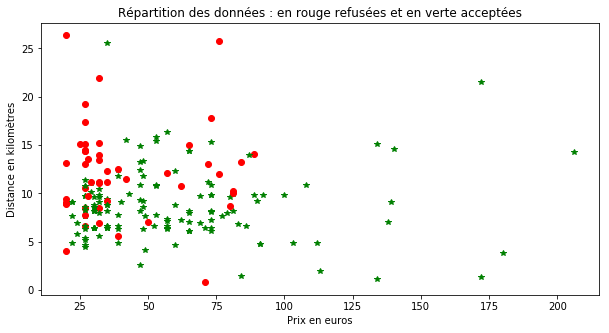

In [15]:
PlotData(X_test,y_test)

### A propos de l'estimation pour une distance et un prix donnée :

### Améliorations envisageables :